In [1]:
# Mount to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!pip install torchvision
!pip install torch.utils
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for torch.utils: filename=torch_utils-0.1.2-py3-none-any.whl size=6187 sha256=1954a9fd5443c06dfff78dfb50b1f8dd9a561e7b4b09beaef2db97494d163e98
  Stored in directory: /root/.cache/pip/wheels/76/08/f0/378d1fe4aac5aa1e21483918d70b7e3428c4faaac0abda4e15
Successfully built torch.utils
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=d471b7f0da41df96c3e75bed9a1e0e979dbbea4e208125a67bda0c915f9329e6
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [8]:
# 데이터셋 파일 다운로드: https://www.kaggle.com/datasets/samuelcortinhas/muffin-vs-chihuahua-image-classification
# 데이터셋 폴더 이름을 Chi_Muf로 임의 변경. 압축 해제는 미리 해야함.
# 구글 드라이브에 업로드까지 완료된 상황이어야함

# 경로 설정
train_dir = "/content/drive/MyDrive/EfficientNet_Chihuahua_Muffin/Chi_Muf/train"
test_dir = "/content/drive/MyDrive/EfficientNet_Chihuahua_Muffin/Chi_Muf/test"

In [9]:
# 데이터 로드 및 전처리

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 이미지 변환 설정
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # EfficientNet 입력 크기
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet 정규화
])

# 데이터셋 로드
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# 클래스 확인
classes = train_dataset.classes
print("클래스:", classes)  # ['chihuahua', 'muffin']


클래스: ['chihuahua', 'muffin']


In [10]:
# EfficientNet 모델 로드 및 클래스 수 조정
from efficientnet_pytorch import EfficientNet
import torch
import torch.nn as nn
import torch.optim as optim

# EfficientNet 모델 불러오기 (사전 학습된 가중치 사용)
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=len(classes))

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 손실 함수와 최적화기
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 226MB/s]


Loaded pretrained weights for efficientnet-b0


In [11]:
# 모델 학습
def train_model(model, train_loader, criterion, optimizer, device, epochs=10):
    model.train()  # 모델을 학습 모드로 설정
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # 이전 경사 초기화
            optimizer.zero_grad()

            # 순전파
            outputs = model(images)
            loss = criterion(outputs, labels)

            # 역전파 및 최적화
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

# 모델 학습 실행
train_model(model, train_loader, criterion, optimizer, device, epochs=10)


Epoch 1/10, Loss: 0.0999
Epoch 2/10, Loss: 0.0545
Epoch 3/10, Loss: 0.0331
Epoch 4/10, Loss: 0.0530
Epoch 5/10, Loss: 0.0295
Epoch 6/10, Loss: 0.0259
Epoch 7/10, Loss: 0.0223
Epoch 8/10, Loss: 0.0128
Epoch 9/10, Loss: 0.0141
Epoch 10/10, Loss: 0.0176


In [12]:
# 모델 성능 평가
def evaluate_model(model, test_loader, device):
    model.eval()  # 모델을 평가 모드로 설정
    correct = 0
    total = 0

    with torch.no_grad():  # 평가 시에는 경사 계산 비활성화
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f"테스트 데이터 정확도: {accuracy*100:.2f}%")

# 모델 평가 실행
evaluate_model(model, test_loader, device)


테스트 데이터 정확도: 98.40%


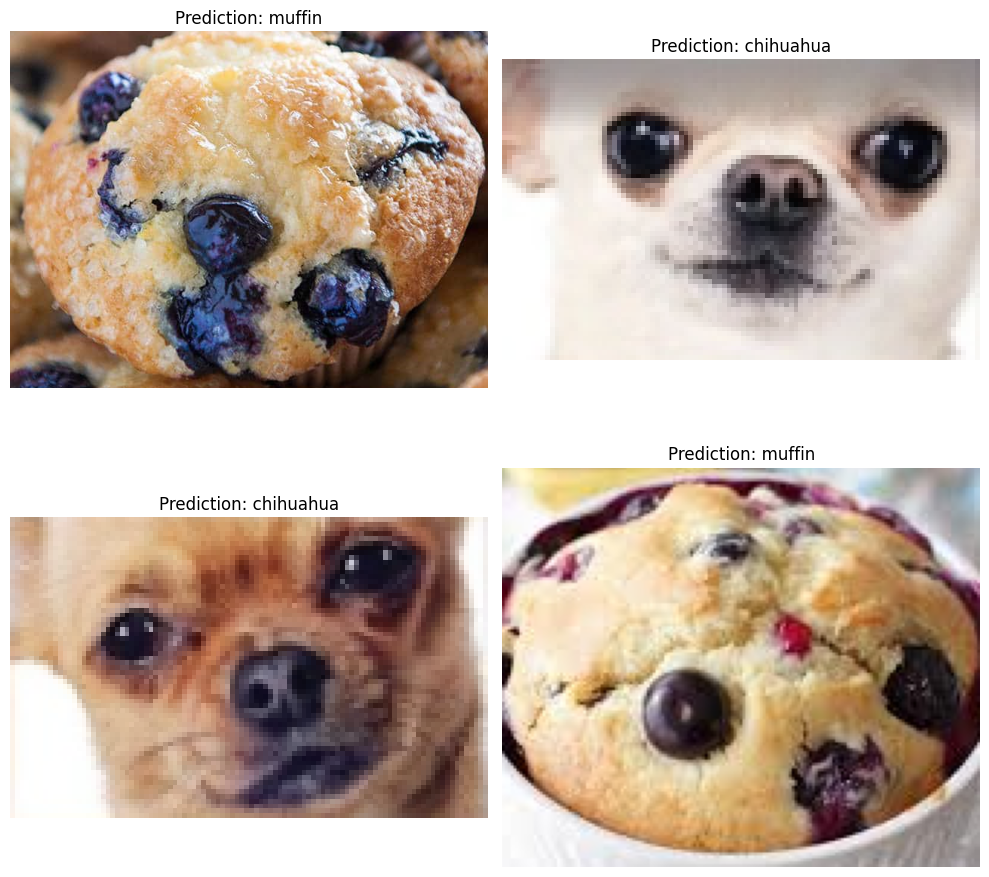

In [31]:
# 새 이미지들로 예측 실행 및 결과 이미지 표시
# /content/drive/MyDrive/EfficientNet_Chihuahua_Muffin/chi_muf_test 에 테스트 이미지 추가 가능
# 이미지 추가 시 아래 코드(def predict_and_show_images의 rows와 cols의 값과 서브플롯의 figsize를 수정하면 됨

import os
import matplotlib.pyplot as plt
from PIL import Image

def predict_and_show_images(image_dir, model, transform, device, classes, rows=2, cols=2):
    model.eval()  # 평가 모드로 전환
    images = os.listdir(image_dir)[:rows * cols]  # 최대 rows * cols 개의 이미지만 사용
    total_images = len(images)

    # 서브플롯 생성 (2x2)
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))  # 서브플롯 크기 조정
    axes = axes.flatten()  # 2D 배열을 1D로 변환

    for i, img_file in enumerate(images):
        img_path = os.path.join(image_dir, img_file)

        # 이미지 로드 및 전처리
        image = Image.open(img_path).convert('RGB')
        processed_image = transform(image).unsqueeze(0).to(device)

        # 모델 예측
        output = model(processed_image)
        _, predicted = torch.max(output, 1)
        prediction = classes[predicted.item()]

        # 서브플롯에 이미지 및 예측 결과 표시
        axes[i].imshow(image)
        axes[i].set_title(f"Prediction: {prediction}", fontsize=12)
        axes[i].axis('off')

    # 빈 서브플롯 숨기기
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# 실행: 2x2 그리드로 예측 결과 출력
test_images_dir = "/content/drive/MyDrive/EfficientNet_Chihuahua_Muffin/chi_muf_test"
predict_and_show_images(test_images_dir, model, transform, device, classes, rows=2, cols=2)




In [32]:
# 학습된 모델 저장
torch.save(model.state_dict(), "/content/drive/MyDrive/EfficientNet_Chihuahua_Muffin/efficientnet_chi_muf.pth")